Output()

Output()

ERROR:pymc.stats.convergence:There were 177 divergences after tuning. Increase `target_accept` or reparameterize.


             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept -11.691  5.411   -22.712     -2.759      0.295    0.213     343.0   
slope       3.509  1.522     0.954      6.593      0.083    0.060     339.0   

           ess_tail  r_hat  
intercept     447.0   1.01  
slope         423.0   1.01  
Frontiera de decizie (ore de studiu): 3.3315135299755463
HDI pentru frontiera de decizie: [1.94275881 4.68631827]


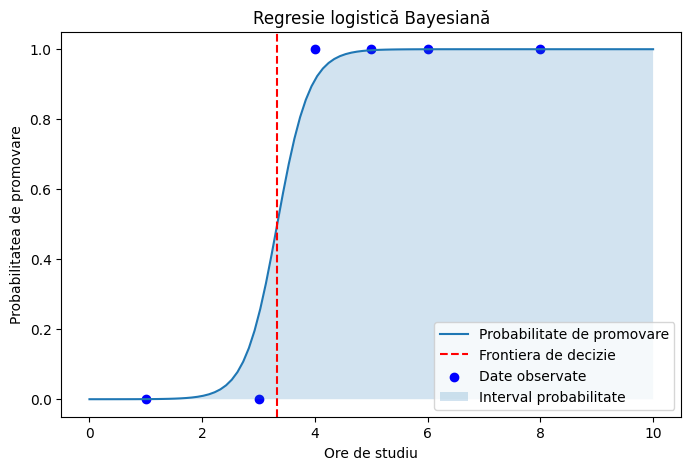

In [9]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Datele problemei
hours = np.array([1, 3, 4, 5, 6, 8])  # ore de studiu
passed = np.array([0, 0, 1, 1, 1, 1])  # promovare (0/1)

# creare model
with pm.Model() as logistic_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # interceptul
    slope = pm.Normal("slope", mu=0, sigma=10)          # panta

    logits = intercept + slope * hours
    p = pm.math.sigmoid(logits)

    y_obs = pm.Bernoulli("y_obs", p=p, observed=passed)

    trace = pm.sample(1000, tune=500, return_inferencedata=True)

# Obținerea rezultatelor
import arviz as az

# Rezumatul coeficienților
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Extragem valori pentru coeficienți
intercept_mean = trace.posterior["intercept"].mean().values
slope_mean = trace.posterior["slope"].mean().values

# Frontiera de decizie: unde probabilitatea de promovare este 0.5
# Frontiera: intercept + slope * x = 0 => x = -intercept / slope
decision_boundary = -intercept_mean / slope_mean
print(f"Frontiera de decizie (ore de studiu): {decision_boundary}")

# Calcul HDI pentru frontiera de decizie
intercepts = trace.posterior["intercept"].values.flatten()
slopes = trace.posterior["slope"].values.flatten()
decision_boundaries = -intercepts / slopes
hdi_decision_boundary = az.hdi(decision_boundaries, hdi_prob=0.95)
print(f"HDI pentru frontiera de decizie: {hdi_decision_boundary}")

# Vizualizare probabilități și frontiera de decizie
x_plot = np.linspace(0, 10, 100)
prob_plot = 1 / (1 + np.exp(-(intercept_mean + slope_mean * x_plot)))

plt.figure(figsize=(8, 5))
plt.plot(x_plot, prob_plot, label="Probabilitate de promovare")
plt.axvline(decision_boundary, color="red", linestyle="--", label="Frontiera de decizie")
plt.scatter(hours, passed, color="blue", label="Date observate")
plt.fill_between(x_plot, prob_plot, alpha=0.2, label="Interval probabilitate")
plt.xlabel("Ore de studiu")
plt.ylabel("Probabilitatea de promovare")
plt.title("Regresie logistică Bayesiană")
plt.legend()
plt.show()

 # Ex 2 - a

 Avem 2 caracteristici: GRE si GPA.

 Deci functia va avea forma:

# $\frac{1}{1+e^{-(β_0+β_1\cdot GRE+β_2\cdot GPA)}}$

Noi va trebui sa estimam $β_0, β_1, β_2 $ pentru a afla cat de mult contribuie fiecare caracteristica la probabilitate.

In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

data = pd.read_csv("Admission.csv")

Y = data['Admission'].values
GRE = data['GRE'].values
GPA = data['GPA'].values

# normalizare
GRE_mean = GRE.mean()
GRE_std = GRE.std()
GPA_mean = GPA.mean()
GPA_std = GPA.std()

# datele normalizate
GRE_std_data = (GRE - GRE_mean) / GRE_std
GPA_std_data = (GPA - GPA_mean) / GPA_std

# construire model
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)

    # formula
    logits = beta0 + beta1 * GRE_std_data + beta2 * GPA_std_data
    p = pm.math.sigmoid(logits)

    y_obs = pm.Bernoulli('y_obs', p=p, observed=Y)

    trace = pm.sample(3000, tune=2000, target_accept=0.95, return_inferencedata=True)

print(az.summary(trace, var_names=["beta0", "beta1", "beta2"]))


Output()

Output()

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0 -0.816  0.114  -1.025   -0.601      0.002    0.001    4984.0    3996.0   
beta1  0.315  0.123   0.085    0.548      0.002    0.001    4461.0    3893.0   
beta2  0.292  0.123   0.065    0.522      0.002    0.001    4856.0    3961.0   

       r_hat  
beta0    1.0  
beta1    1.0  
beta2    1.0  


## Interpretare Rezultate

Am estimat $β_0, β_1, β_2 $. Acestia sunt parametrii in regresia logistica:

# $\frac{1}{1+e^{-(β_0+β_1\cdot GRE+β_2\cdot GPA)}}$

# Ex - 2b

Granita de decizie e acolo unde $p = 0.5$

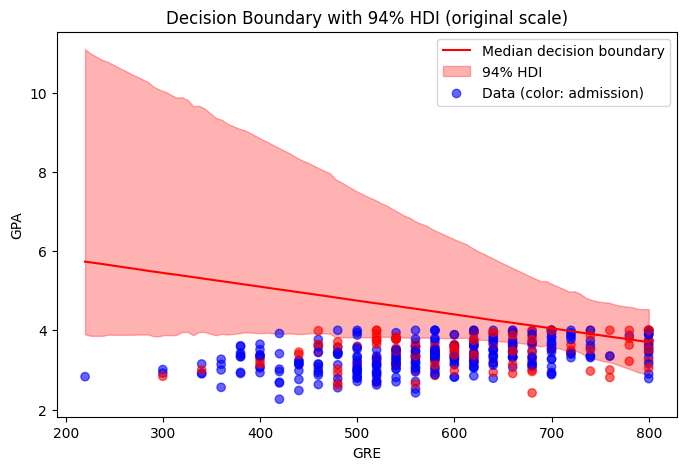

In [3]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

beta0_s = trace.posterior['beta0'].values.flatten()
beta1_s = trace.posterior['beta1'].values.flatten()
beta2_s = trace.posterior['beta2'].values.flatten()

gre_range = np.linspace(GRE.min(), GRE.max(), 100)

gre_range_std = (gre_range - GRE_mean) / GRE_std

# Pentru fiecare valoare GRE, calculăm GPA_std la p=0.5:
# 0 = beta0 + beta1*GRE_std + beta2*GPA_std
# => GPA_std = -(beta0 + beta1*GRE_std)/beta2
all_boundaries_std = []
for gre_val_std in gre_range_std:
    gpa_vals_std = -(beta0_s + beta1_s * gre_val_std) / beta2_s
    all_boundaries_std.append(gpa_vals_std)

all_boundaries_std = np.vstack(all_boundaries_std)

median_line_std = np.median(all_boundaries_std, axis=1)

hdi_lower_std = []
hdi_upper_std = []
for row in all_boundaries_std:
    interval = az.hdi(row, hdi_prob=0.94)
    hdi_lower_std.append(interval[0])
    hdi_upper_std.append(interval[1])

hdi_lower_std = np.array(hdi_lower_std)
hdi_upper_std = np.array(hdi_upper_std)

# denormalizare
median_line = median_line_std * GPA_std + GPA_mean
hdi_lower = hdi_lower_std * GPA_std + GPA_mean
hdi_upper = hdi_upper_std * GPA_std + GPA_mean

plt.figure(figsize=(8,5))
plt.plot(gre_range, median_line, color='red', label='Median decision boundary')
plt.fill_between(gre_range, hdi_lower, hdi_upper, color='red', alpha=0.3, label='94% HDI')

plt.scatter(GRE, GPA, c=Y, cmap='bwr', alpha=0.6, label='Data (color: admission)')

plt.xlabel("GRE")
plt.ylabel("GPA")
plt.title("Decision Boundary with 94% HDI (original scale)")
plt.legend()
plt.show()


# Ex 2 - c

Avem instanta <GRE=550, GPA=3.5>: Ce probabilitate are?

In [8]:
import arviz as az
import numpy as np

beta0_s = trace.posterior['beta0'].values.flatten()
beta1_s = trace.posterior['beta1'].values.flatten()
beta2_s = trace.posterior['beta2'].values.flatten()

gre_val = 550
gpa_val = 3.5

# normalizare
gre_val_std = (gre_val - GRE_mean) / GRE_std
gpa_val_std = (gpa_val - GPA_mean) / GPA_std

logits_vals = beta0_s + beta1_s * gre_val_std + beta2_s * gpa_val_std
p_vals = 1/(1+np.exp(-logits_vals))

# HDI 90%
p_hdi_90 = az.hdi(p_vals, hdi_prob=0.90)
p_mean = np.mean(p_vals)

print(f"Probabilitatea medie de admitere pentru GRE=550, GPA=3.5: {p_mean:.3f}")
print(f"Interval 90% HDI: [{p_hdi_90[0]:.3f}, {p_hdi_90[1]:.3f}]")


Probabilitatea medie de admitere pentru GRE=550, GPA=3.5: 0.303
Interval 90% HDI: [0.261, 0.350]


# Ex 2 - d
Dar pentru <GRE=500, GPA=3.2>?

In [4]:
gre_val2 = 500
gpa_val2 = 3.2

# normalizare
gre_val2_std = (gre_val2 - GRE_mean) / GRE_std
gpa_val2_std = (gpa_val2 - GPA_mean) / GPA_std

logits_vals2 = beta0_s + beta1_s * gre_val2_std + beta2_s * gpa_val2_std
p_vals2 = 1/(1+np.exp(-logits_vals2))

p_hdi_90_2 = az.hdi(p_vals2, hdi_prob=0.90)
p_mean2 = np.mean(p_vals2)

print(f"Probabilitatea medie de admitere pentru GRE=500, GPA=3.2: {p_mean2:.3f}")
print(f"Interval 90% HDI: [{p_hdi_90_2[0]:.3f}, {p_hdi_90_2[1]:.3f}]")


Probabilitatea medie de admitere pentru GRE=500, GPA=3.2: 0.232
Interval 90% HDI: [0.184, 0.276]
